[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ryanharvey1/neuro_py/blob/main/tutorials/explained_variance.ipynb)
&nbsp;
[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/ryanharvey1/neuro_py/main/tutorials/explained_variance.ipynb)
&nbsp;
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/ryanharvey1/neuro_py/main?labpath=tutorials%2Fexplained_variance.ipynb)

# Explained Variance

---

## Setup

In [1]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import nelpy as nel

from neuro_py.ensemble.explained_variance import ExplainedVariance
from neuro_py.io import loading
from neuro_py.plotting.events import plot_peth_fast
from neuro_py.plotting.figure_helpers import set_plotting_defaults

set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r"Z:\home\ryanh\projects\hpc_ctx\figures\panels"

## Section 1: Load spike data, session epochs, and Non-REM epochs

In [2]:
basepath = r"U:\data\HMC\HMC1\day8"

st, cm = loading.load_spikes(basepath, brainRegion="CA1", putativeCellType="Pyr")

epoch_df = loading.load_epoch(basepath)
beh_epochs = nel.EpochArray(epoch_df[["startTime", "stopTime"]].values)

state_dict = loading.load_SleepState_states(basepath)
nrem_epochs = nel.EpochArray(
    state_dict["NREMstate"],
)

epoch_df

,name,startTime,stopTime,environment,behavioralParadigm,notes,manipulation,stimuli,basepath
0,preSleep_210411_064951,0.0000,9544.56315,sleep,NaN,NaN,NaN,NaN,U:\data\HMC\HMC1\day8
1,maze_210411_095201,9544.5632,11752.80635,linear,1,novel,NaN,NaN,U:\data\HMC\HMC1\day8
2,postSleep_210411_103522,11752.8064,23817.68955,sleep,NaN,NaN,NaN,NaN,U:\data\HMC\HMC1\day8


## Section 2: Single output metrics: Explained and Reverse Explained Variance

Here we are calculating explained variance over the entire post-task interval

In [3]:
ev = ExplainedVariance(
    st=st,
    template=beh_epochs[1],  # task
    matching=beh_epochs[2],  # post sleep
    control=beh_epochs[0],  # pre sleep
    window=None,  # window size to calculate correlations, None is the full epoch
)

print(f"explained variance: {ev.ev[0]}, reverse explained variance: {ev.rev[0]}")

explained variance: 0.10214717079493098, reverse explained variance: 0.002093670634183538


You can calculate a *p*-value for the explained variance by comparing the
explained variance to the explained variance of shuffled data (shuffled template
correlations).

> NOTE: This only works when returning single explained variance value, not a
    set of explained variance values over time.

In [4]:
pvalue = ev.pvalue()
print(f"pvalue: {pvalue}")

pvalue: 0.000999000999000999


## Section 3: Time-resolved explained variance


### Section 3.1: Calculate explained variance over time

We can also see the time course of explained variance

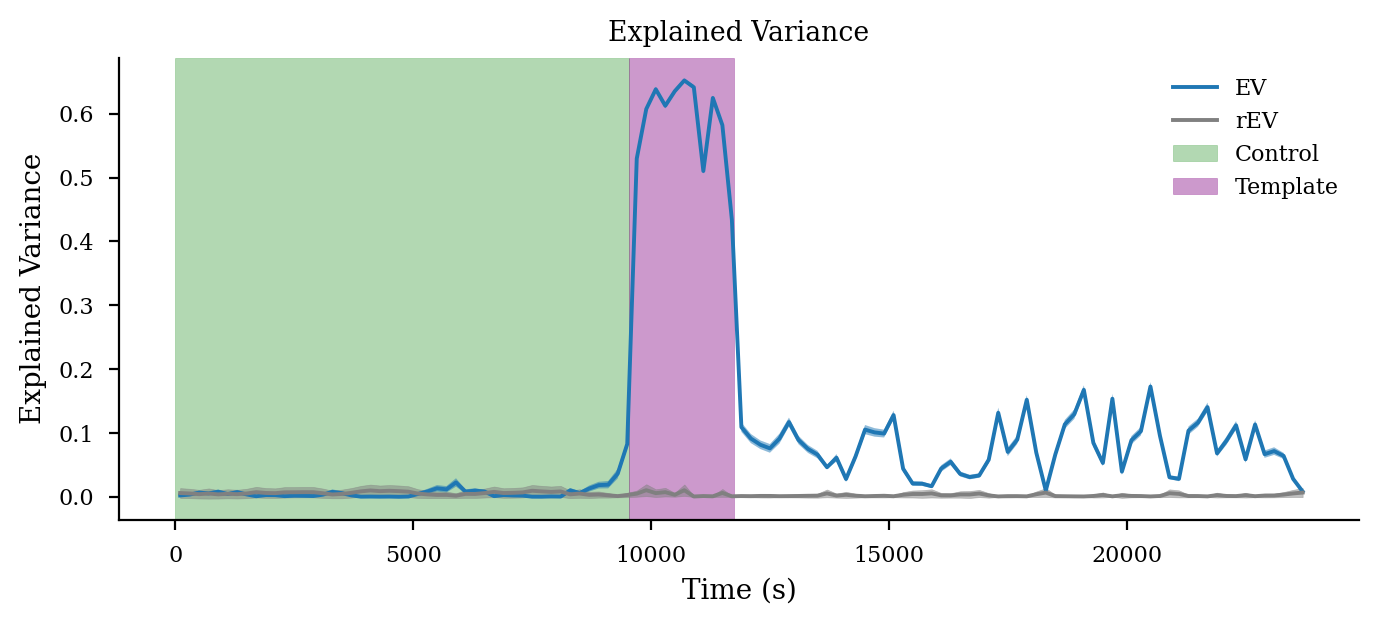

In [5]:
ev = ExplainedVariance(
    st=st,
    template=beh_epochs[1],  # task
    matching=beh_epochs,  # entire epoch (uses start,stop)
    control=beh_epochs[0],  # pre sleep
    window=200,
)

# conviently plot the explained variance with built in method
ev.plot()

### Section 3.2: Inspect when the explained variance is high and low

You can see it is high during the task (by definition it should be) and during NREM sleep

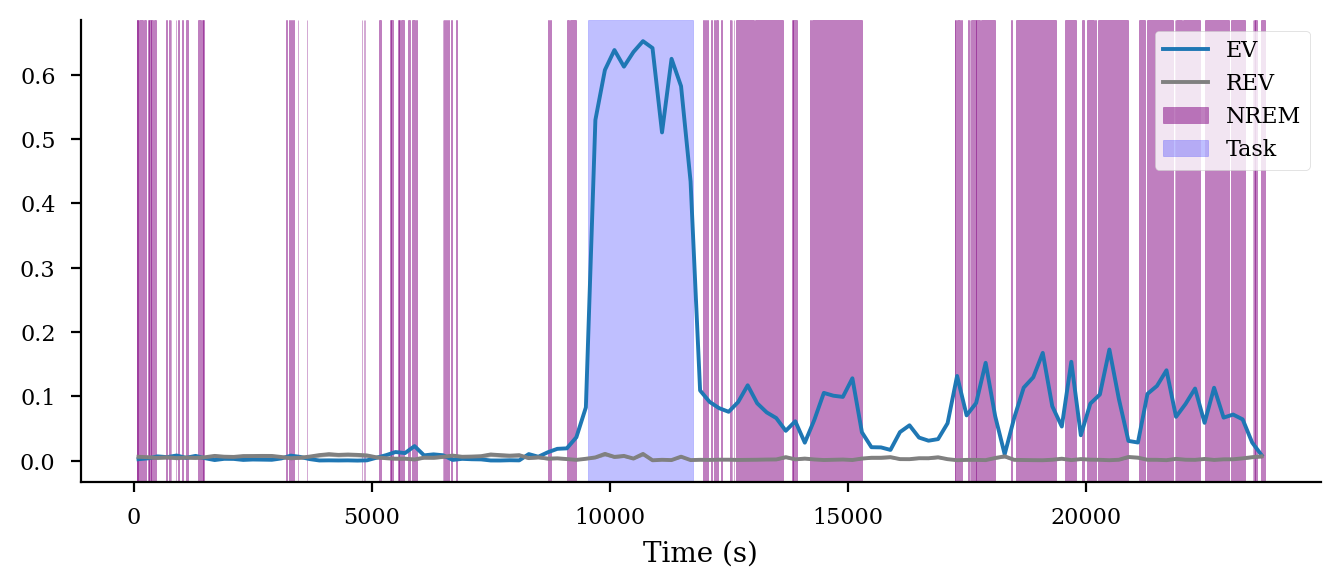

In [6]:
plt.figure(figsize=(8, 3))
ax = plt.gca()
plot_peth_fast(ev.partial_corr.T, ts=ev.matching_time, ax=ax, label="EV")
plot_peth_fast(
    ev.rev_partial_corr.T, ts=ev.matching_time, ax=ax, color="grey", label="REV"
)
plt.axvspan(
    nrem_epochs.data[0, 0],
    nrem_epochs.data[0, 1],
    color="purple",
    alpha=0.5,
    label="NREM",
)
for nrem in nrem_epochs.data:
    plt.axvspan(nrem[0], nrem[1], color="purple", alpha=0.5)
plt.axvspan(
    beh_epochs[1].data[0, 0],
    beh_epochs[1].data[0, 1],
    color="b",
    alpha=0.25,
    zorder=-100,
    label="Task",
)
plt.legend()
plt.show()

### Section 3.3: Use EpochArray to get average explained variance in post-task NREM sleep 

The outcome is similar to above when we used the entire post-task epoch

In [7]:
nrem_ev_avg = ev.ev_signal[beh_epochs[2] & nrem_epochs].mean()
nrem_rev_avg = ev.rev_signal[beh_epochs[2] & nrem_epochs].mean()

print(f"explained variance: {nrem_ev_avg}, reverse explained variance: {nrem_rev_avg}")

explained variance: 0.10133556865860369, reverse explained variance: 0.001632476383922529


---